In [ ]:
# импорт всех необходимых библиотек
import IPython.display as ipd
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import matplotlib.pyplot as plt

In [ ]:
# считывание таблицы с личными данными спикеров
df = pd.read_table('/content/drive/MyDrive/speakers.TXT', sep='|', names = ['ID', 'Sex', 'type', 'time', 'Name'], engine='python')
df

,ID,Sex,type,time,Name
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine
...,...,...,...,...,...
2478,8975,F,train-clean-100,25.11,Daisy Flaim
2479,9000,M,train-other-500,27.26,Ramon Escamilla
2480,9022,F,train-clean-360,25.17,Claire M
2481,9023,F,train-clean-360,25.19,P. J. Morgan


In [ ]:
# Удалим ненужные столбцы. 
del(df['type'])
del(df['time'])
del(df['Sex'])

In [ ]:
# данный код формирует таблицу с директориями звукозаписей для их считывания

folders = os.listdir('/content/drive/MyDrive/test-clean')
data_set = []
data_set_path = []
speaker = []
Name = []
for i in folders:
    
    sub_folders = os.listdir('/content/drive/MyDrive/test-clean/' + str(i))
    if('.DS_Store' in sub_folders):
        sub_folders.remove('.DS_Store')
    for j in sub_folders:
        sub_sub_folders = os.listdir('/content/drive/MyDrive/test-clean/' + str(i) + '/' + str(j))
        if('.DS_Store' in sub_folders):
            sub_sub_folders.remove('.DS_Store')
        for k in sub_sub_folders:
            if (not ('.txt' in k)):
                data_set.append(k)
                data_set_path.append('/content/drive/MyDrive/test-clean/' + str(i) + '/' + str(j) + '/' + str(k))
                speaker.append(i)
                Name.append(df.loc[df['ID'] == int(i), 'Name'].values[0])

data = pd.DataFrame({'File':data_set, 'Path':data_set_path,'Speaker':speaker, 'Name':Name})
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,File,Path,Speaker,Name
0,1284-1180-0009.flac,/content/drive/MyDrive/test-clean/1284/1180/12...,1284,Daniel Anaya
1,8455-210777-0015.flac,/content/drive/MyDrive/test-clean/8455/210777/...,8455,thecheops
2,7729-102255-0019.flac,/content/drive/MyDrive/test-clean/7729/102255/...,7729,Tim Bower
3,3570-5696-0002.flac,/content/drive/MyDrive/test-clean/3570/5696/35...,3570,sarac
4,5142-36377-0006.flac,/content/drive/MyDrive/test-clean/5142/36377/5...,5142,Mary Ballard-Johansson


In [ ]:
# функция расчёта необходимых для обучения признаков
def extract_features(data):
    
    file = data.Path
    X, sample_rate = librosa.load(file, res_type='kaiser_best') 
    # Мел-частотные кепстральные коэфиценты
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    
    # Спектр
    stft = np.abs(librosa.stft(X))
    
    # Кепстр
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
                     
    # Мел
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Спектральный контраст
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    # Имя(id)
    label = data.Name

    return mfccs, chroma, mel, contrast, label

In [ ]:
startTime = datetime.now()
features_extracted = data.apply(extract_features, axis = 1)
datetime.now() - startTime
#Время: 1:04:28

datetime.timedelta(0, 3867, 396595)

In [ ]:
np.save('features_label', features_extracted)
np.save('speakers', data.Name)

In [ ]:
# список признаков
features_extracted = np.load('features_label.npy', allow_pickle=True)
features = []
mfccs = []
chroma = []
mel = []
contrast = []

for i in range(0, len(features_extracted)):
    mfccs.append(features_extracted[i][0])
    chroma.append(features_extracted[i][2])
    mel.append(features_extracted[i][3])
    contrast.append(features_extracted[i][4])
    
    features.append(np.concatenate((features_extracted[i][0],  
                features_extracted[i][1], features_extracted[i][2],
                features_extracted[i][3]), axis=0))

In [ ]:
# Создаем X и y
X = np.array(features)
y = np.array(np.load('speakers.npy', allow_pickle=True))

In [ ]:
dictors_names, y = np.unique(y, return_inverse=True)

In [ ]:
dictors_name_ids_dict = {'Name': dictors_names, 'id': list(range(len(dictors_names)))}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

KNeighborsClassifier
Время выполнения: 0.5 секунд
precision: 0.9468007808269921
recall: 0.9440203562340967
accuracy: 0.9440203562340967
                   Classification report:                   
                         precision    recall  f1-score   support

            AJai Hilton       0.96      0.96      0.96        25
          Bill Kneeland       0.87      1.00      0.93        20
              Brad Bush       1.00      0.92      0.96        24
           Daniel Anaya       0.94      1.00      0.97        16
          David Jenkins       1.00      1.00      1.00        16
                 Dianne       0.83      1.00      0.91        10
         Duncan Murrell       1.00      1.00      1.00        21
          Heather Hogan       1.00      1.00      1.00        14
            Jen Maxwell       0.85      0.70      0.77        33
           Joyce Martin       0.95      1.00      0.97        18
                KalenXI       1.00      1.00      1.00        22
                LadyBu

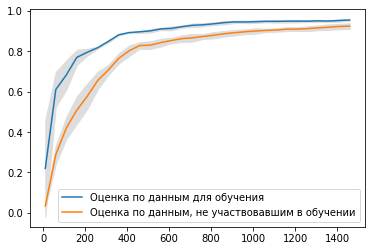

In [ ]:
start_time = time.time()

model = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

class_rep = classification_report(list(y_test), y_pred, target_names = dictors_names)

KNeighborsClassifier_precision = precision_score(y_test, y_pred, average='weighted')
KNeighborsClassifier_recall = recall_score(y_test, y_pred, average='weighted')
KNeighborsClassifier_accuracy = accuracy_score(y_test, y_pred)

print('KNeighborsClassifier')
print(f'Время выполнения: {round(time.time() - start_time, 1)} секунд')
print(f'precision: {KNeighborsClassifier_precision}')
print(f'recall: {KNeighborsClassifier_recall}')
print(f'accuracy: {KNeighborsClassifier_accuracy}')
print(f'{"Classification report:":^60}')
print(class_rep)

train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X, y, 
                                                        train_sizes=[range(10, 1500, 50)]);

plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = 'Оценка по данным для обучения');
plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Оценка по данным, не участвовавшим в обучении');

plt.legend();
plt.fill_between(train_sizes, np.mean(train_scores, axis = 1) - np.std(train_scores, axis = 1), np.mean(train_scores, axis = 1) + np.std(train_scores, axis = 1), color="#DDDDDD");
plt.fill_between(train_sizes, np.mean(test_scores, axis = 1) - np.std(test_scores, axis = 1), np.mean(test_scores, axis = 1) + np.std(test_scores, axis = 1), color="#DDDDDD");

Метод опорных векторов
Время выполнения: 1.3 секунд
precision: 0.9684198590255829
recall: 0.950381679389313
accuracy: 0.950381679389313
                   Classification report:                   
                         precision    recall  f1-score   support

            AJai Hilton       1.00      0.96      0.98        25
          Bill Kneeland       1.00      1.00      1.00        20
              Brad Bush       0.96      1.00      0.98        24
           Daniel Anaya       1.00      1.00      1.00        16
          David Jenkins       1.00      1.00      1.00        16
                 Dianne       1.00      0.80      0.89        10
         Duncan Murrell       1.00      0.95      0.98        21
          Heather Hogan       1.00      1.00      1.00        14
            Jen Maxwell       1.00      0.88      0.94        33
           Joyce Martin       1.00      1.00      1.00        18
                KalenXI       1.00      1.00      1.00        22
                LadyBu

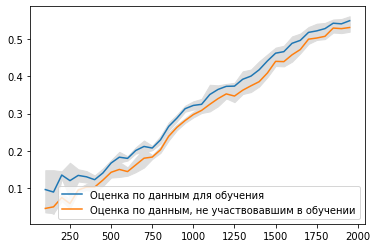

In [ ]:
start_time = time.time()

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

class_rep = classification_report(list(y_test), y_pred, target_names = dictors_names)

SVC_precision = precision_score(y_test, y_pred, average='weighted')
SVC_recall = recall_score(y_test, y_pred, average='weighted')
SVC_accuracy = accuracy_score(y_test, y_pred)

print('Метод опорных векторов')
print(f'Время выполнения: {round(time.time() - start_time, 1)} секунд')
print(f'precision: {SVC_precision}')
print(f'recall: {SVC_recall}')
print(f'accuracy: {SVC_accuracy}')
print(f'{"Classification report:":^60}')
print(class_rep)

train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X, y, 
                                                        train_sizes=[range(100, 2000, 50)]);

plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = 'Оценка по данным для обучения');
plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Оценка по данным, не участвовавшим в обучении');

plt.legend();
plt.fill_between(train_sizes, np.mean(train_scores, axis = 1) - np.std(train_scores, axis = 1), np.mean(train_scores, axis = 1) + np.std(train_scores, axis = 1), color="#DDDDDD");
plt.fill_between(train_sizes, np.mean(test_scores, axis = 1) - np.std(test_scores, axis = 1), np.mean(test_scores, axis = 1) + np.std(test_scores, axis = 1), color="#DDDDDD");

GaussianNB
Время выполнения: 0.1 секунд
precision: 0.8935114384123014
recall: 0.8829516539440203
accuracy: 0.8829516539440203
                   Classification report:                   
                         precision    recall  f1-score   support

            AJai Hilton       0.95      0.80      0.87        25
          Bill Kneeland       0.83      1.00      0.91        20
              Brad Bush       0.61      0.92      0.73        24
           Daniel Anaya       0.79      0.94      0.86        16
          David Jenkins       0.93      0.88      0.90        16
                 Dianne       1.00      0.80      0.89        10
         Duncan Murrell       0.94      0.81      0.87        21
          Heather Hogan       1.00      0.93      0.96        14
            Jen Maxwell       0.76      0.48      0.59        33
           Joyce Martin       0.65      0.94      0.77        18
                KalenXI       1.00      1.00      1.00        22
                LadyBug       1.

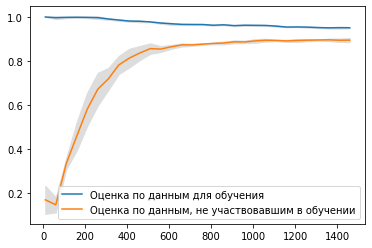

In [ ]:
start_time = time.time()

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

class_rep = classification_report(list(y_test), y_pred, target_names = dictors_names)

GaussianNB_precision = precision_score(y_test, y_pred, average='weighted')
GaussianNB_recall = recall_score(y_test, y_pred, average='weighted')
GaussianNB_accuracy = accuracy_score(y_test, y_pred)

print('GaussianNB')
print(f'Время выполнения: {round(time.time() - start_time, 1)} секунд')
print(f'precision: {GaussianNB_precision}')
print(f'recall: {GaussianNB_recall}')
print(f'accuracy: {GaussianNB_accuracy}')
print(f'{"Classification report:":^60}')
print(class_rep)

train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X, y, 
                                                        train_sizes=[range(10, 1500, 50)]);

plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = 'Оценка по данным для обучения');
plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Оценка по данным, не участвовавшим в обучении');

plt.legend();
plt.fill_between(train_sizes, np.mean(train_scores, axis = 1) - np.std(train_scores, axis = 1), np.mean(train_scores, axis = 1) + np.std(train_scores, axis = 1), color="#DDDDDD");
plt.fill_between(train_sizes, np.mean(test_scores, axis = 1) - np.std(test_scores, axis = 1), np.mean(test_scores, axis = 1) + np.std(test_scores, axis = 1), color="#DDDDDD");

DecisionTree
Время выполнения: 0.7 секунд
precision: 0.83043071656661
recall: 0.8256997455470738
accuracy: 0.8256997455470738
                   Classification report:                   
                         precision    recall  f1-score   support

            AJai Hilton       0.77      0.68      0.72        25
          Bill Kneeland       0.67      0.70      0.68        20
              Brad Bush       0.78      0.75      0.77        24
           Daniel Anaya       0.70      0.88      0.78        16
          David Jenkins       0.77      0.62      0.69        16
                 Dianne       0.90      0.90      0.90        10
         Duncan Murrell       0.85      0.81      0.83        21
          Heather Hogan       1.00      1.00      1.00        14
            Jen Maxwell       0.72      0.88      0.79        33
           Joyce Martin       0.81      0.72      0.76        18
                KalenXI       0.91      0.91      0.91        22
                LadyBug       0.

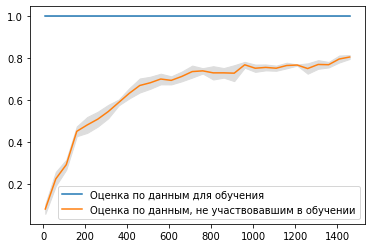

In [ ]:
start_time = time.time()

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

class_rep = classification_report(list(y_test), y_pred, target_names = dictors_names)

DecisionTree_precision = precision_score(y_test, y_pred, average='weighted')
DecisionTree_recall = recall_score(y_test, y_pred, average='weighted')
DecisionTree_accuracy = accuracy_score(y_test, y_pred)

print('DecisionTree')
print(f'Время выполнения: {round(time.time() - start_time, 1)} секунд')
print(f'precision: {DecisionTree_precision}')
print(f'recall: {DecisionTree_recall}')
print(f'accuracy: {DecisionTree_accuracy}')
print(f'{"Classification report:":^60}')
print(class_rep)

train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X, y, 
                                                        train_sizes=[range(10, 1500, 50)]);

plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = 'Оценка по данным для обучения');
plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Оценка по данным, не участвовавшим в обучении');

plt.legend();
plt.fill_between(train_sizes, np.mean(train_scores, axis = 1) - np.std(train_scores, axis = 1), np.mean(train_scores, axis = 1) + np.std(train_scores, axis = 1), color="#DDDDDD");
plt.fill_between(train_sizes, np.mean(test_scores, axis = 1) - np.std(test_scores, axis = 1), np.mean(test_scores, axis = 1) + np.std(test_scores, axis = 1), color="#DDDDDD");

RandomForest
Время выполнения: 2.4 секунд
precision: 0.9915388343632617
recall: 0.9910941475826972
accuracy: 0.9910941475826972
                   Classification report:                   
                         precision    recall  f1-score   support

            AJai Hilton       1.00      1.00      1.00        25
          Bill Kneeland       0.95      1.00      0.98        20
              Brad Bush       1.00      1.00      1.00        24
           Daniel Anaya       1.00      1.00      1.00        16
          David Jenkins       1.00      1.00      1.00        16
                 Dianne       1.00      1.00      1.00        10
         Duncan Murrell       1.00      0.95      0.98        21
          Heather Hogan       1.00      1.00      1.00        14
            Jen Maxwell       1.00      1.00      1.00        33
           Joyce Martin       1.00      1.00      1.00        18
                KalenXI       1.00      1.00      1.00        22
                LadyBug       

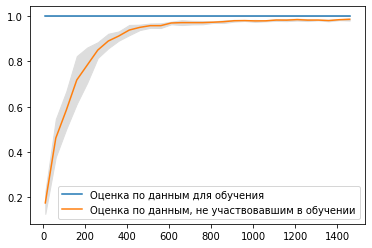

In [ ]:
start_time = time.time()

model = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

class_rep = classification_report(list(y_test), y_pred, target_names = dictors_names)

RandomForest_precision = precision_score(y_test, y_pred, average='weighted')
RandomForest_recall = recall_score(y_test, y_pred, average='weighted')
RandomForest_accuracy = accuracy_score(y_test, y_pred)

print('RandomForest')
print(f'Время выполнения: {round(time.time() - start_time, 1)} секунд')
print(f'precision: {RandomForest_precision}')
print(f'recall: {RandomForest_recall}')
print(f'accuracy: {RandomForest_accuracy}')
print(f'{"Classification report:":^60}')
print(class_rep)

print('Кривая обучения:')

from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X, y, 
                                                        train_sizes=[range(10, 1500, 50)]);

plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = 'Оценка по данным для обучения');
plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Оценка по данным, не участвовавшим в обучении');

plt.legend();
plt.fill_between(train_sizes, np.mean(train_scores, axis = 1) - np.std(train_scores, axis = 1), np.mean(train_scores, axis = 1) + np.std(train_scores, axis = 1), color="#DDDDDD");
plt.fill_between(train_sizes, np.mean(test_scores, axis = 1) - np.std(test_scores, axis = 1), np.mean(test_scores, axis = 1) + np.std(test_scores, axis = 1), color="#DDDDDD");

In [ ]:
compare_df = pd.DataFrame({'accuracy': [KNeighborsClassifier_accuracy,
                                        RandomForest_accuracy,
                                        SVC_accuracy,
                                        GaussianNB_accuracy,
                                        DecisionTree_accuracy],
                           'precision': [KNeighborsClassifier_precision,
                                         RandomForest_precision,
                                         SVC_precision,
                                         GaussianNB_precision,
                                         DecisionTree_precision],
                           'recall': [KNeighborsClassifier_recall,
                                      RandomForest_recall,
                                      SVC_recall,
                                      GaussianNB_recall,
                                      DecisionTree_recall]},
                            index = ['KNeighborsClassifier', 'RandomForest', 'SVC', 'GaussianNB', 'DecisionTree'])
compare_df

,accuracy,precision,recall
KNeighborsClassifier,0.944020,0.946801,0.944020
RandomForest,0.991094,0.991539,0.991094
SVC,0.950382,0.968420,0.950382
GaussianNB,0.882952,0.893511,0.882952
DecisionTree,0.825700,0.830431,0.825700
